## Simulate `build_prediction` function for Inference

Here we mimic the process used in the Inference Detection Layer:
- pick the class with highest probability from mrcnn_class, and it's corresponding bounding box delta
- apply the deltas to the rpn_roi (output_roi)
- convert to image pixel coordinates
-?? Should we apply intra-class NMS??

###  Env set up

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import sys, os, random, pprint
sys.path.append('../')

import tensorflow as tf
import keras.backend as KB
import numpy as np
import skimage.io

import mrcnn.visualize as visualize
import mrcnn.utils as utils

from mrcnn.datagen         import data_generator, load_image_gt, data_gen_simulate
from mrcnn.callbacks       import get_layer_output_1,get_layer_output_2
from mrcnn.utils           import mask_string, parse_image_meta, apply_box_deltas_tf
from mrcnn.prep_notebook   import mrcnn_coco_test
from mrcnn.utils           import log

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)
## At this point, no default session exists

###  Build Inference Model

mrcnn_model, dataset_test, test_generator, mrcnn_config = mrcnn_coco_test(mode='inference')

###  Load Weights

# exclude=["mrcnn_class_logits"] # ,"mrcnn_bbox_fc"]   #, "mrcnn_bbox", "mrcnn_mask"])
exclude = None
mrcnn_model.load_model_weights(init_with = 'last', exclude = exclude)  

###  Layer information

mrcnn_model.layer_info()
# model.keras_model.outputs[0].name

###  Get input images from generator and display

imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')

test_batch_x, test_batch_y = next(test_generator)
# test_batch_x, test_batch_y 

Using TensorFlow backend.


 Initialize CocoConfig object - super
 Linx  Linux
Tensorflow Version: 1.8.0   Keras Version : 2.1.6 
>>> Initialize ModelBase model 
   Mode:  inference
   Model dir :  /users/students/r0653928/models/train_mrcnn_coco
>>> ModelBase initialiation complete
>>> ---Initialize MRCNN model, mode:  inference

----------------------------
>>> Resnet Graph 
----------------------------
     Input_image shape : (?, 1024, 1024, 3)
     After ZeroPadding2D  : (?, 1030, 1030, 3) (?, 1030, 1030, 3)
     After Conv2D padding : (?, 512, 512, 64) (?, 512, 512, 64)
     After BatchNorm      : (?, 512, 512, 64) (?, 512, 512, 64)
     C1 Shape: (?, 256, 256, 64) (?, 256, 256, 64)
     C2 Shape:  (?, 256, 256, 256) (?, 256, 256, 256)
     C3 Shape:  (?, 128, 128, 512) (?, 128, 128, 512)
     C4 Shape:  (?, 64, 64, 1024) (?, 64, 64, 1024)
     C5 Shape:  (?, 32, 32, 2048) (?, 32, 32, 2048)

>>> Feature Pyramid Network (FPN) Graph 
     FPN P2 shape : (None, 256, 256, 256)
     FPN P3 shape : (None, 128, 12

Done (t=3.43s)
creating index...
index created!
 image dir        :  /users/students/r0653928/MLDatasets/coco2014/val2014
 json_path_dir    :  /users/students/r0653928/MLDatasets/coco2014/annotations/instances_val2014.json
 number of images :  40137

Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COCO_DATASET_PATH              /users/students/r0653928/MLDatasets/coco2014
COCO_MODEL_PATH                /users/students/r0653928/PretrainedModels/mask_rcnn_coco.h5
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
DETECTION_PER_CLASS            200
EPOCHS_TO_RUN                  0
FCN_INPUT_SHAPE                [1024 1024]
GPU_COUNT                      1
HEATMAP_SCALE_FACTOR           4
IMAGES_PER_GPU                 

                              Weights     : ['bn4l_branch2a/gamma:0', 'bn4l_branch2a/beta:0', 'bn4l_branch2a/moving_mean:0', 'bn4l_branch2a/moving_variance:0']
                                0 bn4l_branch2a/gamma:0                hdf5 Weights: (256,)  Symbolic Wghts: (256,)
                                1 bn4l_branch2a/beta:0                 hdf5 Weights: (256,)  Symbolic Wghts: (256,)
                                2 bn4l_branch2a/moving_mean:0          hdf5 Weights: (256,)  Symbolic Wghts: (256,)
                                3 bn4l_branch2a/moving_variance:0      hdf5 Weights: (256,)  Symbolic Wghts: (256,)

194 activation_38             Model Layer Name/Type : [('activation_38', <keras.layers.core.Activation object at 0x7f1d29cb4208>)] 
                              Weights     : []

195 res4l_branch2b            Model Layer Name/Type : [('res4l_branch2b', <keras.layers.convolutional.Conv2D object at 0x7f1d29c5dc18>)] 
                              Weights     : ['res4l_branc

   Weights file loaded: /users/students/r0653928/models/train_mrcnn_coco/mrcnn20181013T1338/mrcnn_0028.h5 
 load_model_weights() : MODEL Load weight file COMPLETE    


 Inputs:
 -------
 index:  0    input name : input_image:0                              Type: float32           Shape: (?, 1024, 1024, 3)
 index:  1    input name : input_image_meta:0                         Type: float32           Shape: (?, ?)


 Outputs:
 --------
 layer:  0    output name: mrcnn_detection/PyFunc:0                   Type: float32           Shape: <unknown>
 layer:  1    output name: ROI/rpn_roi_proposals:0                    Type: float32           Shape: (1, ?, ?)
 layer:  2    output name: mrcnn_class/Reshape_1:0                    Type: float32           Shape: (?, 1000, 81)
 layer:  3    output name: mrcnn_bbox/Reshape:0                       Type: float32           Shape: (?, 1000, 81, 4)
 layer:  4    output name: cntxt_layer/pred_heatmap_norm:0            Type: float32           Shape: (1, 256

 Converted to image index -->  [30531]
 batch size is : 1
 load image ud:  30531


<IPython.core.display.Javascript object>


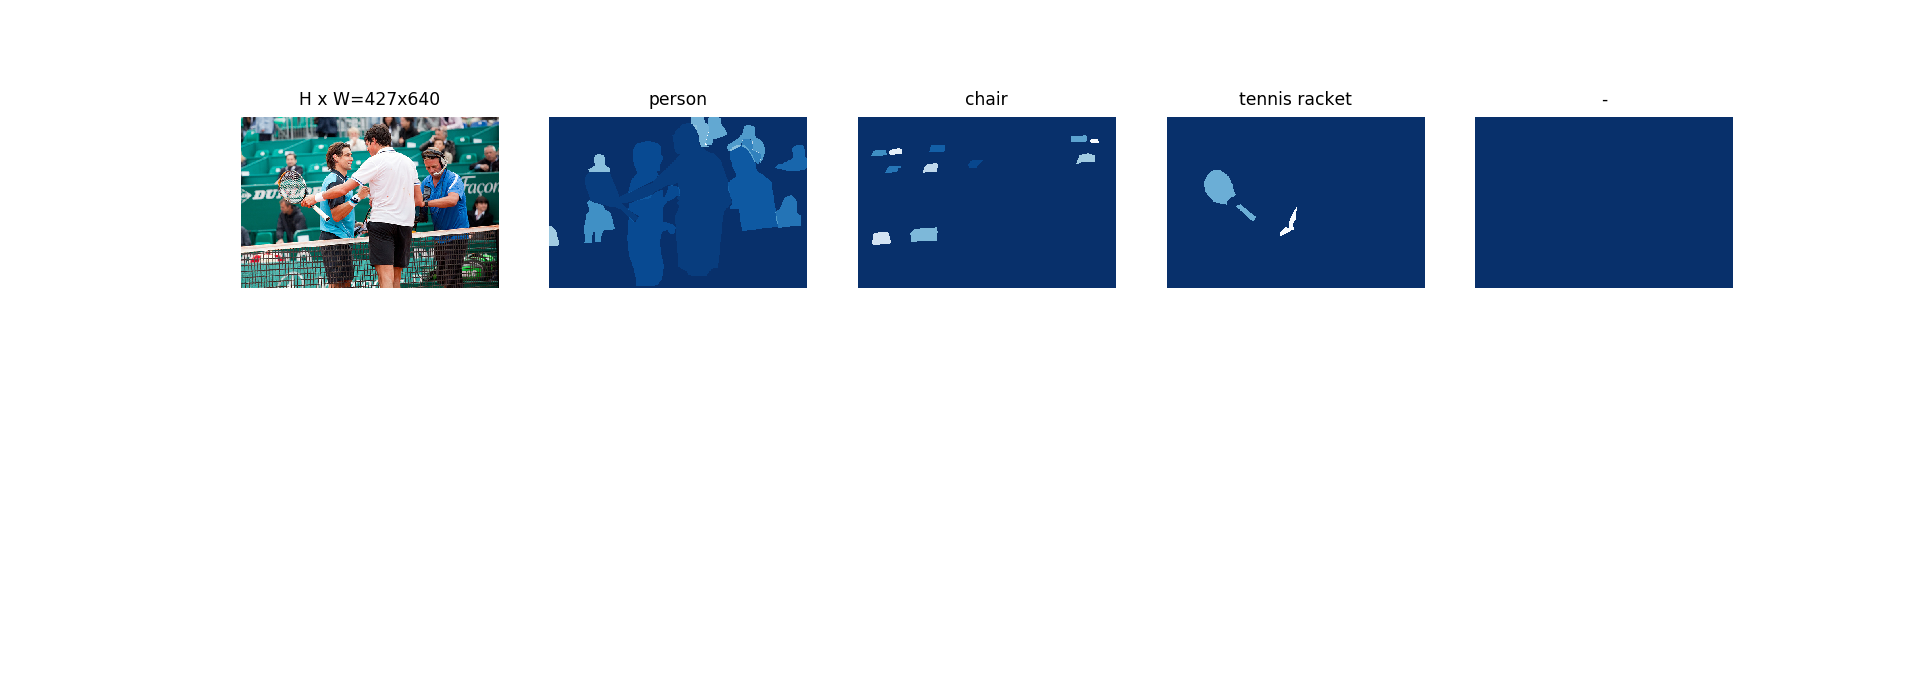

Image id:  30531   Image meta [30531   427   640     3   170     0   853  1024     1     1]
Classes :  ['tennis racket', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'person', 'person', 'person', 'person', 'person', 'chair', 'chair', 'chair', 'chair', 'tennis racket']
 display_instances() : Image shape:  (427, 640, 3)


<IPython.core.display.Javascript object>


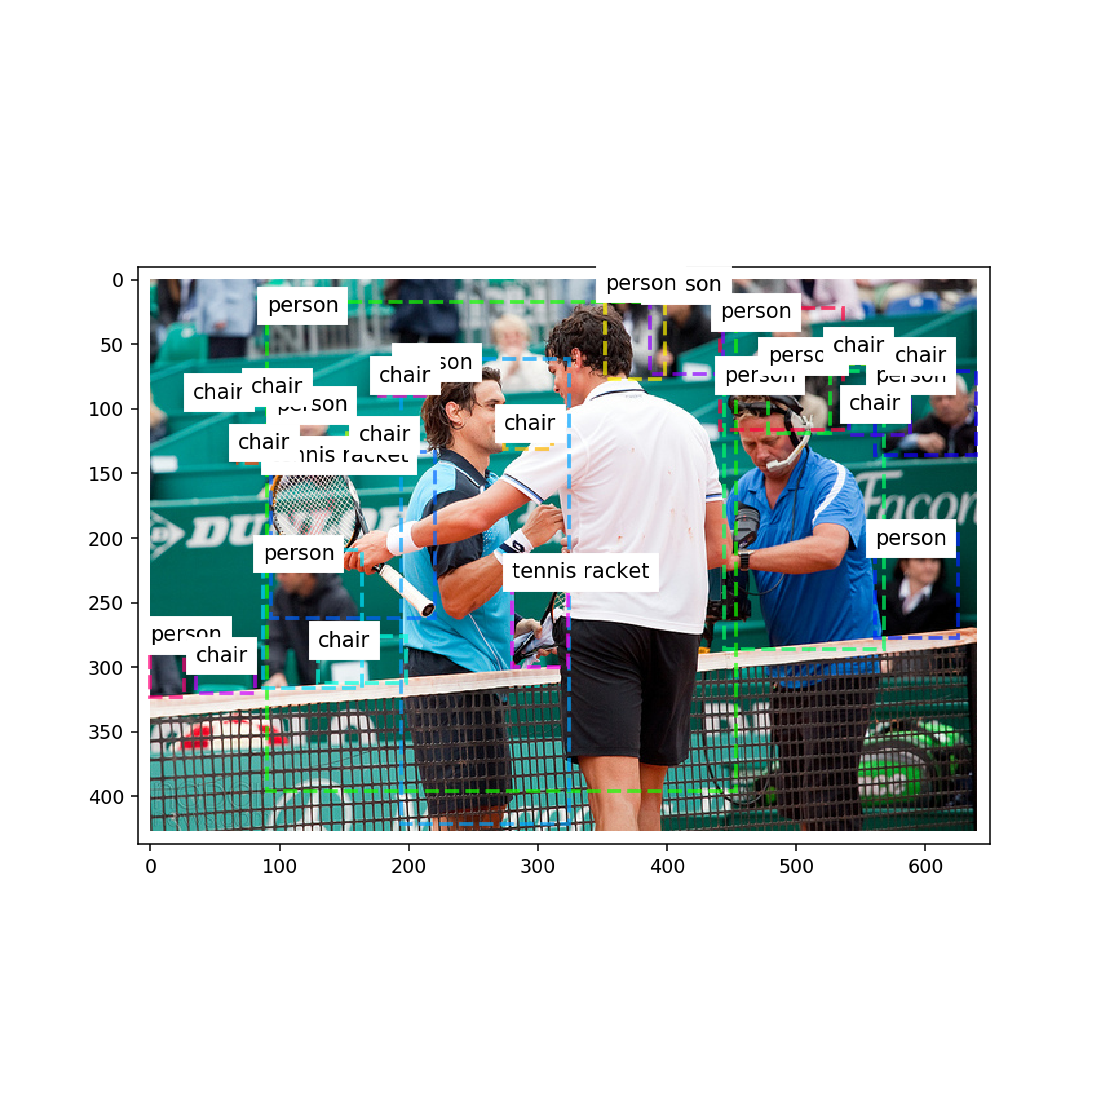

In [3]:
#  5498 -- lots of motorcylces & persons - 
# 26026 -- mountain, skiers, skiboards 
#  7719 -- people, bottles, handbags
# 35347 -- laptops, keyboards and cat
# 27711 -- persons and boats
# 18045 -- person     36769 -- people in meeting room with a 'giraffe'detection?
#  8634 -- person
# 30531 -- tennis players 
#  8645 -- two people
 
load_this = 30531
test_batch_x, test_batch_y = data_gen_simulate(dataset_test, mrcnn_config, load_this)
img_meta  = test_batch_x[imgmeta_idx]

for img_idx in range(mrcnn_config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]    
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)
    print('Image id: ',image_id , '  Image meta', img_meta[img_idx,:10])
    print('Classes : ', [dataset_test.class_names[i] for i in class_ids])
    visualize.display_instances(image, bbox, class_ids, dataset_test.class_names,figsize=(8,8))

###  Print some model information 

In [4]:
mrcnn_model.layer_info()



 Inputs:
 -------
 index:  0    input name : input_image:0                              Type: float32           Shape: (?, 1024, 1024, 3)
 index:  1    input name : input_image_meta:0                         Type: float32           Shape: (?, ?)


 Outputs:
 --------
 layer:  0    output name: mrcnn_detection/PyFunc:0                   Type: float32           Shape: <unknown>
 layer:  1    output name: ROI/rpn_roi_proposals:0                    Type: float32           Shape: (1, ?, ?)
 layer:  2    output name: mrcnn_class/Reshape_1:0                    Type: float32           Shape: (?, 1000, 81)
 layer:  3    output name: mrcnn_bbox/Reshape:0                       Type: float32           Shape: (?, 1000, 81, 4)
 layer:  4    output name: cntxt_layer/pred_heatmap_norm:0            Type: float32           Shape: (1, 256, 256, 81)
 layer:  5    output name: cntxt_layer/pred_heatmap_scores:0          Type: float32           Shape: (1, 81, 100, 11)
 layer:  6    output name: cntxt_layer

In [5]:
### Run computation graph 
#  model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)
model_output = get_layer_output_1(mrcnn_model.keras_model, test_batch_x, [0,1,2,3,4,5,6], 0)

/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (1, 1024, 1024, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (1, 89)
    Wrapper for Detection Layer : call()  <class 'list'> 4
     rpn_proposals_roi  : (1, 1000, 4) <class 'numpy.ndarray'>
     mrcnn_class.shape  : (1, 1000, 81) <class 'numpy.ndarray'>
     mrcnn_bboxes.shape : (1, 1000, 81, 4) <class 'numpy.ndarray'>
     image_meta         : (1, 89) <class 'numpy.ndarray'>


 Detections are:
[[ 216.      277.      853.      729.        1.        0.9995]
 [ 400.      150.      570.      336.       39.        0.9948]
 [ 502.      133.      679.      265.        1.        0.9915]
 [ 293.      707.      764.      915.        1.        0.9869]
 [ 171.      625.      285.      715.        1.        0.9757]
 [ 217.      416.      308.      495.        1.        0.9696]
 [ 485.      904.      614.     1004.        1.        0.9684]
 [ 171.      549.      293.      639.        1.  

In [6]:
### Load input and output tensors
input_image      =  test_batch_x[0]
input_image_meta =  test_batch_x[1]
print(' Input image shape is :', input_image.shape)
h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]

# gt_masks   =  test_batch_x[6]
print(input_image_meta)
print(' Len model_output: ',len(model_output))

 Input image shape is : (1, 1024, 1024, 3)
[[30531   427   640     3   170     0   853  1024     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1]]
 Len model_output:  7


In [7]:
print(len(model_output))
# del mrcnn_detection, rpn_roi_proposals, mrcnn_class, mrcnn_bbox
mrcnn_detections           = model_output[0]          # layer:  0   shape: (1, 100, 6)
rpn_roi_proposals         = model_output[1]          # layer:  1   shape: (1, 1000, 4)
mrcnn_class               = model_output[2]          # layer:  2   shape: (1, 1000, 81)
mrcnn_bbox                = model_output[3]          # layer:  3   shape: (1, 1000, 81, 4)
pred_heatmap_norm         = model_output[4]          # layer:  4   shape: (1, 256, 256, 81)
pred_heatmap_scores       = model_output[5]          # layer:  5   shape: (1, 81, 100, 11)
pred_tensor               = model_output[6]          # layer:  6   shape: (1, 81, 100, 8)
# pred_heatmap_norm         = model_output[4]          # layer:  4   shape: (1, 256, 256, 81)
# pred_heatmap_scores       = model_output[5]          # layer:  5   shape: (1, 81, 100, 11)
# print(type(model_output[4]))
# print(type(output_rois))
for i in model_output:
    print( i.shape)

7
(1, 100, 6)
(1, 1000, 4)
(1, 1000, 81)
(1, 1000, 81, 4)
(1, 256, 256, 81)
(1, 81, 100, 11)
(1, 81, 100, 8)


###  display Pred_Tensor, Pred_heatmap, mrcnn_class

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=210, suppress=True)
img = 0
 
print(' mrcnn_detections  :', mrcnn_detections.shape)   # 1, 100, 6
print(mrcnn_detections[:,:50])    # output_rois * [128, 128,128,128])

# print(' rpn_roi_proposals : ', rpn_roi_proposals.shape)  # 1,1000,4
# print(' rpn_roi_proposals[0,:15]: \n', rpn_roi_proposals[0,:15] * [h, w,h,w])

# print(' mrcnn_class :',mrcnn_class.shape)   # 1,1000,81
# print( mrcnn_class[0,:5])

# print(' mrcnn_bbox  :', mrcnn_bbox.shape)   # 1,1000,81,4
# print( mrcnn_bbox[0,:5])

# print(' pred_tensor  :', pred_tensor.shape)   # 1, 100, 6
# print(pred_tensor[:,:,:5])    # output_rois * [128, 128,128,128])

# print(' pred_heatmap_scores  :', pred_heatmap_scores.shape)   # 1, 100, 6
# print(pred_heatmap_scores[:,:,:5])    # output_rois * [1024, 128,128,128])

# print(' rpn_class  : ', rpn_class.shape)                # 1,4092, 2
# print(' rpn_bbox   : ', rpn_bbox.shape)                 # 1,4092, 4 

####  Display `mrcnn_detections` tensor 

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())a
print('detection shape is ', mrcnn_detections.shape)
img = 0
for img in range(1):
    print('Image ', img , ' ------------')
    print(mrcnn_detections[img,:15] )

##  `build_predictions_inference()`   


Sample `mrcnn_detections:`

`[ 43.        63.        80.        92.         4.         0.999993]
 [ 64.         7.        78.        42.         2.         0.99999 ]
 [  0.         0.         0.         0.         0.         0.      ]`

###  Setup tensors to be passed to function

In [ ]:
# print('Current Keras Session :', KB.query_session())

np.set_printoptions(linewidth=250, precision=6, threshold = 10000)
# mrcnn_bbox  = tf.identity(mrcnn_bbox)
# mrcnn_class = tf.identity(mrcnn_class)
sess = KB.get_session()
print('Session obtained from Keras', sess)

import mrcnn.utils as utils
detected_rois = tf.identity(mrcnn_detections)
config = mrcnn_config

###  Build `Pred_Tensor`

In [ ]:
with sess.as_default():
    
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES
    h, w            = config.IMAGE_SHAPE[:2]
    num_rois        = config.DETECTION_MAX_INSTANCES 
    num_cols        = KB.int_shape(detected_rois)[-1]
    det_per_class   = config.DETECTION_PER_CLASS
    print()
    print('  > build_predictions Inference mode ()')
    print('    config image shape  : ', config.IMAGE_SHAPE, 'h:',h,'w:',w)
    print('    num_rois            : ', num_rois )
    print('    num_cols            : ', num_cols )
    print('    detected_rois.shape : ', KB.int_shape(detected_rois))

with sess.as_default():
    #---------------------------------------------------------------------------
    # Build a meshgrid for image id and bbox to use in gathering of bbox delta information 
    #   indexing = 'ij' provides matrix indexing conventions
    #---------------------------------------------------------------------------
    batch_grid, bbox_grid = tf.meshgrid( tf.range(batch_size, dtype=tf.int32),
                                         tf.range(num_rois, dtype=tf.int32), indexing = 'ij' )
    print('    batch_grid: ', KB.int_shape(batch_grid))
    print( batch_grid.eval())
    print('    bbox_grid : ', KB.int_shape(bbox_grid))
    print( bbox_grid.eval())
    print(detected_rois)
#     print(detected_rois.eval()[0,:75])

with sess.as_default():
    #---------------------------------------------------------------------------
    # column -2 contains the prediceted class 
    #  (NOT USED)   pred_classes_exp = tf.to_float(tf.expand_dims(pred_classes ,axis=-1))    
    #---------------------------------------------------------------------------
    pred_classes = tf.to_int32(detected_rois[...,4])
    print(pred_classes.eval())

with sess.as_default():
    ##------------------------------------------------------------------------------------
    ##  Build Pred_Scatter: tensor of bounding boxes by Image / Class
    ##------------------------------------------------------------------------------------
    ## sequence id is used to preserve the order of rois as passed to this routine
    ##  This may be important in the post matching process but for now it's not being used.
    ## 22-09-18 : We need to use this sequence as the sort process based on score will cause
    ##            mismatch between the bboxes from output_rois and roi_gt_bboxes
    ##------------------------------------------------------------------------------------
    sequence = tf.ones_like(pred_classes, dtype = tf.int32) * (bbox_grid[...,::-1] + 1) 
    sequence = tf.to_float(tf.expand_dims(sequence, axis = -1))   
    print('    shape of sequence      : ', sequence.shape)
    pred_array  = tf.concat([ detected_rois, sequence], axis=-1, name = 'pred_array')
     
    scatter_ind = tf.stack([batch_grid , pred_classes, bbox_grid],axis = -1)
    pred_scatt  = tf.scatter_nd(scatter_ind, pred_array, [batch_size, num_classes, num_rois, pred_array.shape[-1]])
    print('    pred_array      : ', pred_array.shape)  
    print(pred_array.eval())    
    print('    scatter_ind     : ', scatter_ind.shape)
#     print(scatter_ind.eval())
    print('    pred_scatter    : ', pred_scatt.get_shape())
    print(pred_scatt.eval()[0,57,:20,:])        

with sess.as_default():    
    ##--------------------------------------------------------------------------------------------
    ##  Apply a per class score normalization using the score column (COLUMN 5)
    ##  
    ##--------------------------------------------------------------------------------------------
    normalizer   = tf.reduce_max(pred_scatt[...,5], axis = -1, keepdims=True)
    normalizer   = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    norm_score   = tf.expand_dims(pred_scatt[...,5]/normalizer, axis = -1)
    pred_scatt   = tf.concat([pred_scatt, norm_score],axis = -1)   
    print('    - Add normalized score --\n')
    print('    normalizer             : ', normalizer.shape)  
    print('    norm_score             : ', norm_score.shape)
    print('    pred_scatter           : ', pred_scatt.get_shape())
    print(pred_scatt.eval()[0,57,:20,:])

with sess.as_default(): 
    ##------------------------------------------------------------------------------------
    ## Sort pred_scatt in each class dimension based on sequence number, to push valid  
    ##      to top for each class dimension
    ##
    ## 22-09-2018: sort is now based on sequence which was added as last column
    ##             (previously sort was on bbox scores)
    ##------------------------------------------------------------------------------------
    _, sort_inds = tf.nn.top_k(pred_scatt[...,6], k=pred_scatt.shape[2])
    
    # build indexes to gather rows from pred_scatter based on sort order    
    class_grid, batch_grid, roi_grid = tf.meshgrid(tf.range(num_classes),tf.range(batch_size), tf.range(num_rois))
#     roi_grid_exp = tf.to_float(tf.expand_dims(roi_grid, axis = -1))
    
    gather_inds  = tf.stack([batch_grid , class_grid, sort_inds],axis = -1)
    pred_tensor  = tf.gather_nd(pred_scatt, gather_inds[...,:det_per_class,:], name = 'pred_tensor')    

    print('    sort_inds              : ', type(sort_inds)   , ' shape ', sort_inds.shape)
    print('    class_grid             : ', type(class_grid)  , ' shape ', class_grid.get_shape())
    print('    batch_grid             : ', type(batch_grid)  , ' shape ', batch_grid.get_shape())
    print('    roi_grid shape         : ', type(roi_grid)    , ' shape ', roi_grid.get_shape()) 
    print('    roi_grid_exp           : ', type(roi_grid_exp), ' shape ', roi_grid_exp.get_shape())
    print('    gather_inds            : ', type(gather_inds) , ' shape ', gather_inds.get_shape())
    print('    pred_tensor            : ', pred_tensor.get_shape())
    print(pred_tensor.eval()[0,1,:])

####  find value occuring with highest frequency in pred_classes

In [ ]:
tcf = tf.contrib.framework
with sess.as_default():
    print(pred_classes.eval())
    class_ids, idxs, class_counts = tf.unique_with_counts(pred_classes[0])
    print(class_ids.eval())
    print(class_counts.eval())
    print(idxs.eval())
    print('using bincount')
    bin_count = tf.bincount(pred_classes)[1:]
    print(bin_count.eval())
    
    print('using contrib.framework')
    argsort = tcf.argsort(bin_count, direction="DESCENDING")
    print(argsort.eval())
    
    
    print('using.top_k')
    print(tf.shape(class_counts).eval())
    sort_list, sort_inds = tf.nn.top_k(class_counts, k=tf.shape(class_counts)[0])
    print(sort_list.eval())
    print(sort_inds.eval())
          

####  Display for visual check - `pred_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
with sess.as_default():
    np.set_printoptions(linewidth=150, precision=6)
    print('scatter shape is ', pred_scatter.get_shape())
    temp = pred_tensor
    print('pred_tensor shape is ', temp.shape)
    img = 0
    for k in range(4):
        print('Image ', img , '/ Class ',k,' ------------')
        print(temp[img,k].shape)

## `build_heatmap_inference()`

###  `build_mask_routine_inf()`

In [ ]:
def build_hm_score(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        input_row      :    [y1, x1, y2, x2] in absolute (non-normalized) scale

    Returns
    -----------
        gaussian_sum :      sum of gaussian heatmap vlaues over the area covered by the bounding box
        bbox_area    :      bounding box area (in pixels)
        weighted_sum :      gaussian_sum * bbox_score
    '''
    heatmap_tensor, input_bbox, input_norm_score = input_list
    
    with tf.variable_scope('mask_routine'):
        y_extent     = tf.range(input_bbox[0], input_bbox[2])
        x_extent     = tf.range(input_bbox[1], input_bbox[3])
        Y,X          = tf.meshgrid(y_extent, x_extent)
        bbox_mask    = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(bbox_mask,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
        # mask_sum    =  tf.reduce_sum(mask)
        mask_applied = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
        bbox_area    = tf.to_float((input_bbox[2]-input_bbox[0]) * (input_bbox[3]-input_bbox[1]))
        gaussian_sum = tf.reduce_sum(mask_applied)

#         Multiply gaussian_sum by score to obtain weighted sum    
#         weighted_sum = gaussian_sum * input_row[5]

#       Replaced lines above with following lines 21-09-2018
        # Multiply gaussian_sum by normalized score to obtain weighted_norm_sum 
        weighted_norm_sum = gaussian_sum * input_norm_score    # input_list[7]

    return tf.stack([gaussian_sum, bbox_area, weighted_norm_sum], axis = -1)



### `build_heatmap_inference()`

In [ ]:
# def build_heatmap_inference(in_tensor, config, names = None):

names = ['pred_heatmap']
in_tensor = pred_tensor

####  Check prob_grid for nan values

#### Scatter Gaussians out to appropriate classes and apply reduce_sum

####  Call `build_mask_routine()` to build scores from `gauss_sum` and `gauss_norm`

Testing demonstrated that the we obtain the same NORMALIZED score from `gauss_sum` and `gauss_norm`
we will use the scores and heatmap generated from `gauss_norm` 

####  Display gauss_sum

In [ ]:
with sess.as_default():
#     np_gauss_sum = tf.reduce_sum(gauss_sum,axis=[2,3]).eval()
    np_gauss_sum = tf.reduce_sum(gauss_sum,axis=[2,3]).eval()
print(np_gauss_sum.shape)
print(np_gauss_sum)


#### Display gauss_norm

In [ ]:
# del np_gauss_sum
with sess.as_default():
    np_gauss_norm = tf.reduce_sum(gauss_norm,axis=[2,3]).eval()
print(np_gauss_norm.shape)
print(np_gauss_norm)


#### Check `scores` generated by `build_mask_routine`

In [ ]:
# with sess.as_default(): 
#     np_scores_sum  = scores_from_sum.eval()
#     np_scores_norm = scores_from_norm.eval()
print(np_scores_sum.shape , np_scores_norm.shape) 

both = np.concatenate((np_scores_sum, np_scores_norm), axis = -1)
print(both.shape)
print(both[0,1])
# print(np.sum(np_scores[24:43,0]))
del np_scores_sum
del np_scores_norm
del both

###  Append `in_tensor` and `scores_from_sum` to form `bbox_scores`

In [ ]:
with sess.as_default():    
    # consider the two new columns for reshaping the gaussian_bbox_scores
    
    bbox_scores = tf.concat([in_tensor, scores_from_sum], axis = -1,name = names[0]+'_scores')
    print('    in_tensor       : ', in_tensor.shape)
    print('    boxes_scores    : ', bbox_scores.shape)   
    print('   ', bbox_scores.name)
    print('    bbox_scores  (FINAL)    : ', bbox_scores.shape, ' Keras tensor ', KB.is_keras_tensor(bbox_scores) )     
    

In [ ]:
#     new_shape   = tf.shape(in_tensor)+ [0,0,0, tf.shape(scores)[-1]]        
#     bbox_scores = tf.reshape(bbox_scores, new_shape)
#     bbox_reshape = [in_tensor.shape[0], in_tensor.shape[1],in_tensor.shape[2],in_tensor.shape[3] + scores.shape[-1]]
#     bbox_scores = tf.reshape(bbox_scores, bbox_reshape)
#     print('    in_tensor shape         : ', in_tensor.shape)
#     print('    new shape is            : ', bbox_reshape)
#     print('    in_tensor_flattened     : ', in_tensor_flattened.shape)
#     print('    Scores shape            : ', scores.shape)   # [(num_batches x num_class x num_rois ), 3]
#     print('    boxes_scores (reshaped) : ', bbox_scores.shape)   
    
    ##--------------------------------------------------------------------------------------------
    ## Normalize computed score above, and add it to the heatmap_score tensor as last column
    ##--------------------------------------------------------------------------------------------
#     scr_L2norm   = tf.nn.l2_normalize(bbox_scores[...,-1], axis = -1)   # shape (num_imgs, num_class, num_rois)
#     scr_L2norm   = tf.expand_dims(scr_L2norm, axis = -1)
#     np_scr_L2norm = scr_L2norm.eval()
    
    ##--------------------------------------------------------------------------------------------
    # shape of tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True) is (num_imgs, num_class, 1)
    #  This is a regular normalization that moves everything between [0, 1]. 
    #  This causes negative values to move to -inf, which is a problem in FCN scoring. 
    # To address this a normalization between [-1 and +1] was introduced in FCN.
    # Not sure how this will work with training tho.
    ##--------------------------------------------------------------------------------------------
#     normalizer   = tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
#     normalizer   = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
#     scr_norm     = bbox_scores[...,-1]/normalizer
#     scr_norm     = tf.expand_dims(scr_norm, axis = -1, name="scr_norm_exp_dims")                             # shape (num_imgs, num_class, 32, 1)

    #--------------------------------------------------------------------------------------------
    # this normalization moves values to [-1, +1] which we use in FCN, but not here. 
    #--------------------------------------------------------------------------------------------    
    # reduce_max = tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
    # reduce_min = tf.reduce_min(bbox_scores[...,-1], axis = -1, keepdims=True)  ## epsilon    = tf.ones_like(reduce_max) * 1e-7
    # scr_norm   = (2* (bbox_scores[...,-1] - reduce_min) / (reduce_max - reduce_min)) - 1     
    # scr_norm   = tf.where(tf.is_nan(scr_norm),  tf.zeros_like(scr_norm), scr_norm, name = "Where4")  
    #--------------------------------------------------------------------------------------------
#     bbox_scores    = tf.concat([bbox_scores, scr_norm, scr_L2norm], axis = -1,name = names[0]+'_scores')    
#     print('    bbox_scores  (FINAL)    : ', bbox_scores.shape, ' Keras tensor ', KB.is_keras_tensor(bbox_scores) )      
    
    #     gauss_scores         = KB.identity(bbox_scores, name = names[0]+'_scores')    
    #     print('    gauss_scores       final shape : ', gauss_scores.shape      ,' Keras tensor ', KB.is_keras_tensor(gauss_scores) )  

###  Arrange gauss_heatmap

In [ ]:
with sess.as_default():
#     gauss_heatmap      = KB.identity(tf.transpose(gauss_sum,[0,2,3,1]), name = names[0])

    gauss_heatmap      = tf.transpose(gauss_sum,[0,2,3,1], name = names[0])
    gauss_heatmap_norm = tf.transpose(gauss_norm,[0,2,3,1], name = names[0])

    print('    gauss_heatmap       shape : ', gauss_heatmap.shape     ,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap) )  
    print('    gauss_heatmap_norm  shape : ', gauss_heatmap_norm.shape,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap_norm) )  
#     print(gauss_heatmap)
    
#     gauss_heatmap_norm   = KB.identity(tf.transpose(gauss_norm,[0,2,3,1]), name = names[0]+'_norm')
#     print('    gauss_heatmap_norm final shape : ', gauss_heatmap_norm.shape,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap_norm) )  
#     gauss_heatmap_L2norm = KB.identity(tf.transpose(gauss_L2norm,[0,2,3,1]), name = names[0]+'_L2norm')
 
    print('    complete')


###  Simulate `build_mask_routine()`:


In [ ]:
with sess.as_default():
    heatmap_tensor = temp_reshape[25]
    input_row = bboxes[25]
    print(' input row is :' , input_row.eval())
    y_extent     = tf.range(input_row[0], input_row[2])
    x_extent     = tf.range(input_row[1], input_row[3])
    print(y_extent.eval())
    print(x_extent.eval())
    Y,X          = tf.meshgrid(y_extent, x_extent)
    bbox_mask    = tf.stack([Y,X],axis=2)       
#     print(bbox_mask.eval().shape)
#     print(bbox_mask.eval())
    mask_indices = tf.reshape(bbox_mask,[-1,2])    # reshape to [#positions in mask, 2]
#     print(mask_indices.eval().shape)
    mask_indices = tf.to_int32(mask_indices)
    mask_size    = tf.shape(mask_indices)[0]
    mask_updates = tf.ones([mask_size], dtype = tf.float32)    
    mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
#     print(mask.shape)
#     mask_sum    =  tf.reduce_sum(mask)
#     print(mask_sum.eval())
     
    mask_applied = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
    bbox_area    = tf.to_float((input_row[2]-input_row[0]) * (input_row[3]-input_row[1]))
    np_bbox_area = bbox_area.eval()
    gaussian_sum = tf.reduce_sum(mask_applied)
    ratio        = gaussian_sum * input_row[5]
#     np_gaussian_sum = gaussian_sum.eval()
#     ratio        = gaussian_sum / bbox_area 
#     ratio        = tf.where(tf.is_nan(ratio),  0.0, ratio)  

In [ ]:
# print(utils.mask_string(np_mask[122:190,665:710]))
print(np_gaussian_sum)
with sess.as_default():
    np_sum = tf.reduce_sum(heatmap_tensor).eval()
    print(np_sum)
    print(heatmap_tensor.shape)

In [ ]:
with sess.as_default():
    print(scores2_reshape[0,1].eval())

In [ ]:
with sess.as_default():    


In [ ]:
bbox_scores  = tf.concat([in_tensor, scores_reshape, scores2_reshape], axis = -1)

In [ ]:
with sess.as_default():
    np_bbox_scores = bbox_scores.eval()

###  Current method for bbox_scores

In [ ]:
with sess.as_default():    
    # consider the two new columns for reshaping the gaussian_bbox_scores
    
    bbox_scores = tf.concat([in_tensor_flattened, scores], axis = -1)
    print('    boxes_scores            : ', bbox_scores.shape)   
    
#     new_shape   = tf.shape(in_tensor)+ [0,0,0, tf.shape(scores)[-1]]        
#     bbox_scores = tf.reshape(bbox_scores, new_shape)
    bbox_reshape = [in_tensor.shape[0], in_tensor.shape[1],in_tensor.shape[2],in_tensor.shape[3] + scores.shape[-1]]
    bbox_scores = tf.reshape(bbox_scores, bbox_reshape)
    print('    in_tensor shape         : ', in_tensor.shape)
    print('    new shape is            : ', bbox_reshape)
    print('    in_tensor_flattened     : ', in_tensor_flattened.shape)
    print('    Scores shape            : ', scores.shape)   # [(num_batches x num_class x num_rois ), 3]
    print('    boxes_scores (reshaped) : ', bbox_scores.shape)   
    
    ##--------------------------------------------------------------------------------------------
    ## Normalize computed score above, and add it to the heatmap_score tensor as last column
    ##--------------------------------------------------------------------------------------------
#     scr_L2norm   = tf.nn.l2_normalize(bbox_scores[...,-1], axis = -1)   # shape (num_imgs, num_class, num_rois)
#     scr_L2norm   = tf.expand_dims(scr_L2norm, axis = -1)
#     np_scr_L2norm = scr_L2norm.eval()
    
    ##--------------------------------------------------------------------------------------------
    # shape of tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True) is (num_imgs, num_class, 1)
    #  This is a regular normalization that moves everything between [0, 1]. 
    #  This causes negative values to move to -inf, which is a problem in FCN scoring. 
    # To address this a normalization between [-1 and +1] was introduced in FCN.
    # Not sure how this will work with training tho.
    ##--------------------------------------------------------------------------------------------
    normalizer   = tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
    normalizer   = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    scr_norm     = bbox_scores[...,-1]/normalizer
    scr_norm     = tf.expand_dims(scr_norm, axis = -1, name="scr_norm_exp_dims")                             # shape (num_imgs, num_class, 32, 1)

    #--------------------------------------------------------------------------------------------
    # this normalization moves values to [-1, +1] which we use in FCN, but not here. 
    #--------------------------------------------------------------------------------------------    
    # reduce_max = tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
    # reduce_min = tf.reduce_min(bbox_scores[...,-1], axis = -1, keepdims=True)  ## epsilon    = tf.ones_like(reduce_max) * 1e-7
    # scr_norm   = (2* (bbox_scores[...,-1] - reduce_min) / (reduce_max - reduce_min)) - 1     
    # scr_norm   = tf.where(tf.is_nan(scr_norm),  tf.zeros_like(scr_norm), scr_norm, name = "Where4")  
    #--------------------------------------------------------------------------------------------
    bbox_scores    = tf.concat([bbox_scores, scr_norm, scr_L2norm], axis = -1,name = names[0]+'_scores')    
    print('    bbox_scores  (FINAL)    : ', bbox_scores.shape, ' Keras tensor ', KB.is_keras_tensor(bbox_scores) )      
    
    #     gauss_scores         = KB.identity(bbox_scores, name = names[0]+'_scores')    
    #     print('    gauss_scores       final shape : ', gauss_scores.shape      ,' Keras tensor ', KB.is_keras_tensor(gauss_scores) )  

###  Arrange gauss_heatmap

with sess.as_default():
#     gauss_heatmap      = KB.identity(tf.transpose(gauss_sum,[0,2,3,1]), name = names[0])
    gauss_heatmap      = tf.transpose(gauss_sum,[0,2,3,1], name = names[0])
    print('    gauss_heatmap_norm final shape : ', gauss_heatmap.shape,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap) )  
    print(gauss_heatmap)
    
#     gauss_heatmap_norm   = KB.identity(tf.transpose(gauss_norm,[0,2,3,1]), name = names[0]+'_norm')
#     print('    gauss_heatmap_norm final shape : ', gauss_heatmap_norm.shape,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap_norm) )  
#     gauss_heatmap_L2norm = KB.identity(tf.transpose(gauss_L2norm,[0,2,3,1]), name = names[0]+'_L2norm')
 
    print('    complete')

#     return   gauss_heatmap_norm, gauss_scores  # , gauss_heatmap   gauss_heatmap_L2norm    # [gauss_sum, gauss_scatt, means, covar]    
    

#### Check bbox_scores generated

In [ ]:
with sess.as_default():
#     np_bbox_scores = bbox_scores.eval()
    print(bbox_scores)
print(np_bbox_scores.shape)
print(np_bbox_scores[0,1,:,:])

####  Check normalized scores 

In [ ]:
#     np_normalizer = normalizer.eval()
#     np_scr_norm  = scr_norm.eval()

#  Since we corrected normalzier above, there is no need to check and replace nan values with 0

#     scr_norm     = tf.where(tf.is_nan(scr_norm),  tf.zeros_like(scr_norm), scr_norm, name = "Where3")     
#     np_scr_norm2 = scr_norm.eval()
  
# print(np_normalizer.shape)
# print(np_normalizer)
# with sess.as_default():
# np_scr_norm  = scr_norm.eval()

# print(np_scr_norm.shape)
# print(np.isnan(np_scr_norm))
# print(np_scr_norm)

# print(np_scr_norm2.shape)
# print(np.isnan(np_scr_norm2))

# print(np_scr_L2norm.shape)
# print(np.isnan(np_scr_norm))

### Display heatmap for `gauss_sum` and `gauss_norm`

In [ ]:
# del np_gauss_norm, np_gauss_sum, np_in_tensor, np_bbox_scores
with sess.as_default():
#     np_gauss_sum = gauss_sum.eval()
    np_in_tensor = in_tensor.eval()
#       np_gauss_map = gauss_heatmap_norm.eval()
print(np_gauss_map.shape, np_in_tensor.shape)
np_gauss_map = np.transpose(np_gauss_map, axes=(0,3,1,2))
print(np_gauss_map.shape, np_in_tensor.shape)

In [ ]:
from mrcnn.visualize import plot_3d_heatmap, plot_2d_heatmap,plot_bbox_heatmap_one_class, plot_gaussian
%matplotlib notebook

print('Image id: ',image_id)
img = 0
cls = 1
ttl = 'Non-normalized - image: {}'.format(img)
plot_gaussian( np_gauss_map, 0, [1,3,4], title = 'My figure', width = 7, height = 7)
# plot_bbox_heatmap_one_class(np_gauss_sum[img], np_in_tensor[img], class_id = cls, num_bboxes = 25, title = ttl, width = 20)

In [ ]:
# ttl = 'Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
# ttl = 'Normalized - image: {}'.format(img)
# plot_3d_heatmap(pred_heatmap_norm[img], title = ttl, width = 20)

# ttl = 'Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap[img], title = ttl, width = 20)
# ttl = 'Normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap_norm[img], title = ttl, width = 20)

# ttl = 'Ground Truth Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(gt_heatmap[img], title = ttl, width = 20)
# ttl = 'Ground Truth Normalized - image: {}'.format(img)
# plot_3d_heatmap(gt_heatmap_norm[img], title = ttl, width = 20)

# ttl = 'Non-normalized - image: {}'.format(img)
# plot_2d_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)
# ttl = 'Normalized - image: {}'.format(img)
# plot_2d_heatmap(pred_heatmap_norm[img], pred_heatmap_scores[img], width=15, title=ttl)

####  Display for visual check - `pred_heatmap_scores` is the final result which is passed from  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6, suppress=True)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_heatmap_scores shape is ', pred_heatmap_scores.shape)
for img in [0,1,2]:
    for k in range(4):
        print('Image ', img , '/ Class ',k,' ------------')
        print(np.min(pred_heatmap_scores[img,k,:,8]))
        print(pred_heatmap_scores[img,k])

####  Display for visual check - `GT_HEATMAP_SCORES` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
print('gt_heatmap_scores shape is ', gt_heatmap_scores.shape)
img = 1
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_heatmap_scores[img,k])

####  Display for visual check - `pred_heatmap_norm` is the final result from  `build_gaussian_tf()`

In [ ]:
print(pred_heatmap_norm.shape)
temp = pred_heatmap_norm
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    


####  Display for visual check - `fcn_heatmap_norm` is the final result from  `FCN`

In [ ]:
temp = fcn_heatmap
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img / cls ',i,'/', j, ' sum:',temp_sum[i,j])
        print('sum: ', np.sum(temp[i,:,:,j] ),' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    

#### Display sum, min, max of heatmaps

In [ ]:
sess = KB.get_session()
with sess.as_default():
    temp = fcn_heatmap
    np.set_printoptions(linewidth=150, threshold=10000)
    print('  output shapes :',  temp.get_shape())
    temp_sum = tf.reduce_sum(temp, [2,3])
    temp_min = tf.reduce_min(temp, [2,3])
    temp_max = tf.reduce_max(temp, [2,3])
    temp_avg = tf.reduce_mean(temp, [2,3])
    print('temp_sum is ', temp_sum.shape)
    for i in range(5):
        for j in range(4):
                print('img/cls ',i,'/', j,'  sum:',temp_sum[i,j], 'min',temp_min[i,j] ,'max',temp_max[i,j] ,'avg',temp_avg[i,j])


####  Display for visual check - `gt_heatmap_scores`  and `fcn_heatmap_scores` 

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())

img = 0
for i in [1,2,3]:
    for j in range(32):
        print('Image ', img , '/ Class ',i,' ------------')

        print(gt_heatmap_scores[img,i,j])
        print(pred_heatmap_scores[img,i,j])
        print(fcn_heatmap_scores[img,i,j,[0,1,2,3,4,5,11,12,13,14,15]])

### Print out values of `pred_tensor` , `pred_array`, ..

In [ ]:
with sess.as_default():
    scatt = pred_scatt.eval()
    test = pred_tensor.eval()

####  Test that refined_rois is correctly working in `clip_to_window_tf` 

In [ ]:
with sess.as_default():
    test_np = refined_rois.eval()
    test_tf = refined_rois_clipped.eval()
    window_np = np.array([0,0,128,128])
 
    print(window_np.shape)
    for i in range(5):
#         print('Before', i)
#         print(test_np[i])
        test_np[i] = clip_to_window(window_np, test_np[i])
#         print('After', i)
#         print(test_np[i])
#         print('   tensor flow')
#         print(test_tf[i])
        
    for i in range(5):
      all_equal = np.all(test_np == refined_rois_clipped.eval())
      print('i: ', i, '--- EQUAL : ', all_equal)


####  Test that pred_classes and pred_deltas have been properly selected when using tf.gather_nd ()

In [ ]:
with sess.as_default():
    tmp0 = pred_classes.eval()
    tmp1 = mrcnn_bbox.eval()
    tmp2 = pred_deltas.eval()
    tmp4 = mrcnn_class.eval()
    tmp3 = pred_scores2.eval()
    tmp5 = pred_scores.eval()
    

for i in range(5):
    for j in range(32):
        print('i: ', i, ' j :', j,'--- class: ',tmp0[i,j],'---------------')
    #     print(tmp0[i,j])
        print(tmp1[i,j])
        print(' ===> ', tmp2[i,j])
        print(' mrcnn_score: ', tmp4[i,j,tmp0[i,j]], ' pred_score:', tmp5[i,j,0], 'pred_score2: ', tmp3[i,j])


####  Verify refined_rois generated by TF and NP are equal when using `apply_box_deltas_tf( )`

In [ ]:
from mrcnn.utils import apply_box_deltas, apply_box_deltas_tf
with sess.as_default():
    refined_rois_tf = apply_box_deltas_3d(output_rois, pred_deltas).eval()
    print(' refined rois_tf: ', refined_rois_tf.shape, refined_rois_tf.dtype)
    tmp = []
    bxs = output_rois.eval()
    dlt = pred_deltas.eval()
    for i in range(5):
        tmp.append(apply_box_deltas(bxs[i], dlt[i]))
    refined_rois_np = np.asarray(tmp)
    print(' refined rois_np: ', refined_rois_np.shape,refined_rois_np.dtype)
    print(' refined rois_np == refined rois_tf ?? :', np.all(refined_rois_tf[0,1] == refined_rois_np[0,1]))

#     for i in range(5):
#         for j in range(32):
#             all_eq = np.all(refined_rois_tf[0,1] == refined_rois_np[0,1])
#             if ~all_eq:
#                 print(' Not equal : ',i,'/',j)
#                 print(refined_rois_tf[i,j])
#                 print(refined_rois_np[i,j])
#             else:
#                 print(' equal : ',i,'/',j)
print(refined_rois_tf[0])
print(refined_rois_np[0])


#### Window manipulation 

In [ ]:
with sess.as_default():    
    X = tf.range(18, dtype=tf.int32)
    Y = tf.range(18, dtype=tf.int32)
    X, Y = tf.meshgrid(X, Y)

    # duplicate (repeat) X and Y into a  batch_size x rois_per_image tensor
    print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
    ones = tf.ones([34 , 1, 1], dtype = tf.int32)
    rep_X = ones * X
    rep_Y = ones * Y 
    print('    Ones:    ', ones.shape)                
    print('    ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
    print('    ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)


In [ ]:
with sess.as_default():
    
    window          = tf.constant([[0,1,2,3]], dtype =tf.float32)   
    print(window.shape)
#     high_vals = tf.stack([window[:,2],window[:,3], window[:,2], window[:,3]], axis = -1)
#     print(' hv: ', high_vals.shape)
#     print(high_vals.eval())
    high_vals = tf.expand_dims(high_vals, axis = 1)
#     print(' hv: ', high_vals.shape)
    high_vals = tf.tile(high_vals,[1,32,1])    
#     print(high_vals.shape)
#     print(high_vals[0].eval())
#     print(high_vals[1].eval())
#     print(high_vals[2].eval())

    
    
    low_vals  = tf.stack([window[:,0],window[:,1], window[:,0], window[:,1]], axis = -1)
    print(' lv: ', low_vals.shape)
    print(low_vals.eval())
    low_vals = tf.expand_dims(low_vals, axis = 1)
    print(' lv: ', low_vals.shape)
    low_vals = tf.tile(low_vals,[5, 32,1])    
    print(' lv: ', low_vals.shape)
    print(low_vals[0].eval())
    print(low_vals[1].eval())
    print(low_vals[2].eval())     
    print(low_vals[3].eval())         
    print(low_vals[4].eval())     

###  Test `means`, `covar`, `gauss_grid`, and `gauss_sum ` between development version and final version

In [ ]:
print(pred_tensor.get_shape(), pred_tensor2.get_shape())
print(np.all(pred_tensor.eval() == pred_tensor2.eval()))
# tst1 = means.eval()
# tst2 = means2.eval()
# print(tst1.shape, tst2.shape)

# print(tst1[0,:10])
# print()
# print(tst2[0,:10])
# print(np.all(tst1 == tst2))
# print()
# del tst1, tst2

## Proposal Layer

In [ ]:
import mrcnn.utils as utils
sess = KB.get_session()


In [ ]:
def apply_box_deltas_graph(boxes, deltas):
    """
    Applies the given deltas to the given boxes.

    x,y,w,h : Bounding Box coordinates, width, and height

    Boxes:  is the (y1, x1, y2, x2) of the anchor boxes
    deltas: [dy, dx, log(dh), log(dw)] 
            is the predicted bounding box returned from the RPN layer (in test phase)
            These are considered the targets or ground truth 
    Refer to Bounding Box Regression - R-CNN paper 
    Regression targets are calculated as follows:   
      tx = (GTx - PRx)/PRw       ty = (Gy - Py)/Ph
      th = log(Gw/Pw)         tw = log(Gh/Ph)
    ---------------------------------------------------------------------------------            
    
    boxes:  [N, 4] where each row is [y1, x1, y2, x2]
    deltas: [N, 4] where each row is [dy, dx, log(dh), log(dw)]
    """
    # Convert to y, x, h, w
    height   = boxes[:, 2] - boxes[:, 0]
    width    = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height   *= tf.exp(deltas[:, 2])
    width    *= tf.exp(deltas[:, 3])
    
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    result = tf.stack([y1, x1, y2, x2], axis=1, name="apply_box_deltas_out")
    return result


def clip_boxes_graph(boxes, window):
    """
    clip refined anchor boxes such that they remain within the dimensions of the image 
    boxes:  [N, 4] each row is y1, x1, y2, x2
    window: [4] in the form y1, x1, y2, x2 
    """
    # Split corners
    wy1, wx1, wy2, wx2 = tf.split(window, 4)   #  0, 0 , 128,128
    y1 , x1 , y2 , x2  = tf.split(boxes, 4, axis=1)
    
    # Clip
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)   # ensure  wy1 <= y1 <= wy2
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    clipped = tf.concat([y1, x1, y2, x2], axis=1, name="clipped_boxes")
    return clipped

def suppress_small_boxes_graph(boxes, scores, area_threshold ):
    """
    supress boxes with area less than area_threshold
    boxes:  [N, 4] each row is y1, x1, y2, x2
    
    """
    bx_area = (boxes[...,2]-boxes[...,0])*(boxes[...,3]-boxes[...,1])
    selected_idxs   = tf.where(tf.greater_equal(bx_area, area_threshold))
    selected_boxes  = tf.gather_nd(boxes, selected_idxs)
    selected_scores = tf.gather_nd(scores, selected_idxs)
    padding   = tf.maximum(tf.shape(boxes)[0] - tf.shape(selected_boxes)[0], 0)

#     print(' box area       : ', bx_area.shape)    
#     print(' selected_idxs  : ', tf.shape(selected_idxs).eval())
#     print(' selected scores: ', tf.shape(selected_scores).eval())
#     print(' Req padding    : ', padding.eval())
    
    selected_boxes  = tf.pad(selected_boxes, [(0, padding), (0, 0)])    
    selected_scores = tf.pad(selected_scores, [(0, padding)])    
    return selected_boxes, selected_scores

def nms(normalized_boxes, scores):
    proposal_count = model.config.POST_NMS_ROIS_TRAINING
    rms_threshold  = model.config.RPN_NMS_THRESHOLD
    indices = tf.image.non_max_suppression(normalized_boxes, 
                                           scores, 
                                           proposal_count,
                                           nms_threshold, 
                                           name="rpn_non_max_suppression")

    proposals = tf.gather(normalized_boxes, indices)
    # Pad if needed
    padding   = tf.maximum(proposal_count - tf.shape(proposals)[0], 0)
    proposals = tf.pad(proposals, [(0, padding), (0, 0)])
    return proposals

In [ ]:
with sess.as_default():
    scores = rpn_class[:, :, 1]
    print(scores.shape)
    deltas = rpn_bbox
    print('deltas shape', deltas.shape)
    deltas = deltas * np.reshape(model.config.RPN_BBOX_STD_DEV, [1, 1, 4])
    print('deltas shape', deltas.shape)
    anchors = model.anchors
    print('model.anchors.shape', model.anchors.shape)
    pre_nms_limit = min(6000, model.anchors.shape[0])
    print('pre nms limit', pre_nms_limit)

    ix = tf.nn.top_k(scores, pre_nms_limit, sorted=True,name="top_anchors").indices

    ## gather top scores (pre_nms_limit = min(6000, # anchors) number of scores from scores)        
    scores  = utils.batch_slice([scores, ix], lambda x, y: tf.gather(x, y), model.config.IMAGES_PER_GPU) 
    print(' selected scores: ',scores.shape)

    ## get corrsponding deltas generated by RPN
    deltas  = utils.batch_slice([deltas, ix], lambda x, y: tf.gather(x, y), model.config.IMAGES_PER_GPU)
    print(' selected deltas: ',deltas.shape)
    anchors = utils.batch_slice(         ix , lambda x   : tf.gather(anchors, x), model.config.IMAGES_PER_GPU, names=["pre_nms_anchors"])
    print(' selected anchors: ',anchors.shape)
    boxes = utils.batch_slice([anchors, deltas],
                              lambda x, y: apply_box_deltas_graph(x, y),model.config.IMAGES_PER_GPU,
                              names=["refined_anchors"])
    print(' delta applied boxes :', boxes.shape)

    # Clip to image boundaries. [batch, N, (y1, x1, y2, x2)]
    height, width = model.config.IMAGE_SHAPE[:2]
    window = np.array([0, 0, height, width]).astype(np.float64)
    print(' window is ', window)
    clipped_boxes  = utils.batch_slice(boxes, 
                                   lambda x: clip_boxes_graph(x, window), model.config.IMAGES_PER_GPU,
                                   names=["refined_anchors_clipped"])

    print(' clipped boxes :', clipped_boxes.shape)
    
    ## Suppress proposal boxes (and  corresponding score) if the area is less than ROI_AREA_THRESHOLD
    roi_area_threshold = 2
    mod_boxes, mod_scores = utils.batch_slice([clipped_boxes,scores], 
                            lambda x, y: suppress_small_boxes_graph(x, y, roi_area_threshold), model.config.IMAGES_PER_GPU,
                            names=["mod_boxes", "mod_scores"])  
    print(' mod boxes :', tf.shape(mod_boxes).eval())
    print(' mod_scores:', tf.shape(mod_scores).eval())   
    
    normalized_boxes = tf.cast(mod_boxes / np.array([[height, width, height, width]]), tf.float32)
    print(' normalized boxes:', normalized_boxes.shape)

    proposals = utils.batch_slice([normalized_boxes, mod_scores], nms, model.config.IMAGES_PER_GPU)
    print('     Output: Prposals shape : ', proposals.shape, tf.shape(proposals).eval())
    

####  Analyze proposals results 

In [ ]:
sess = KB.get_session()
with sess.as_default():
    proposals = tf.identity(rpn_proposal_rois)  # <--- this uses the results from the model 

    bx_area = (proposals[...,2]-proposals[...,0])*(proposals[...,3]-proposals[...,1])
    print(' proposals :', tf.shape(proposals).eval())
    print(' box area : ', tf.shape(bx_area).eval())
    
    selected_idxs = tf.where(tf.less_equal(bx_area, (2/(128*128))) )
    print('selected bx:', tf.shape(selected_idxs).eval())
    
    print(selected_idxs.eval())
    selected_area      = tf.gather_nd(bx_area  , selected_idxs)
    selected_proposals = tf.gather_nd(proposals, selected_idxs)
    print('selected proposals shape', tf.shape(selected_proposals).eval())
    print(selected_proposals[0:30].eval())
    print('selected area shape', tf.shape(selected_area).eval())
    print(selected_area[0:30].eval())
    

####  Analyze bounding box areas 

In [ ]:
with sess.as_default():
    print(' boxes :', boxes.shape)
    for i in [0,10,17,25,26,34,39]:
        print(i, ' non-clipped ', boxes[0, i].eval())
    bx_area = (boxes[...,2]-boxes[...,0])*(boxes[...,3]-boxes[...,1])
    print(' box area : ', bx_area.shape)
    np.set_printoptions(linewidth=130,precision=4,threshold=4096)
    print(bx_area[:, :20].eval(session=sess))
    small_idxs = tf.where(bx_area < 1)
    print('small bx:', tf.shape(small_idxs).eval())
    print(small_idxs[0:10].eval())
    small_area  = tf.gather_nd(bx_area, small_idxs)
    small_boxes = tf.gather_nd(boxes, small_idxs)
    print('small boxes shape', tf.shape(small_boxes).eval())
    print(small_boxes[0:30].eval())
    print('small area shape', tf.shape(small_area).eval())
    print(small_area[0:30].eval())
    

##  Plot heatmaps


### Plot 2D heatmap of  one `pred_heatmap` distribution generated in `build_heatmap`

In [9]:
from mrcnn.visualize import plot_one_bbox_heatmap, plot_3d_heatmap, plot_3d_heatmap_all_classes, plot_2d_heatmap,plot_2d_heatmap_with_bboxes
import matplotlib as plt

%matplotlib notebook
print('Image id: ',image_id)
img_id = 0
class_names = dataset_test.class_names

Image id:  30531


####  2D plot of `pred_heatmap_norm` returned from model : `model_pred_heatmap_norm`

(1, 256, 256, 81)
Image : 0  ClassIds: [0, 1, 14, 39, 57]
height is  30
256 256
x1, x2...shapes: (81, 100) (81, 100) (81, 100) (81, 100) (81, 100) (81, 100)


<IPython.core.display.Javascript object>


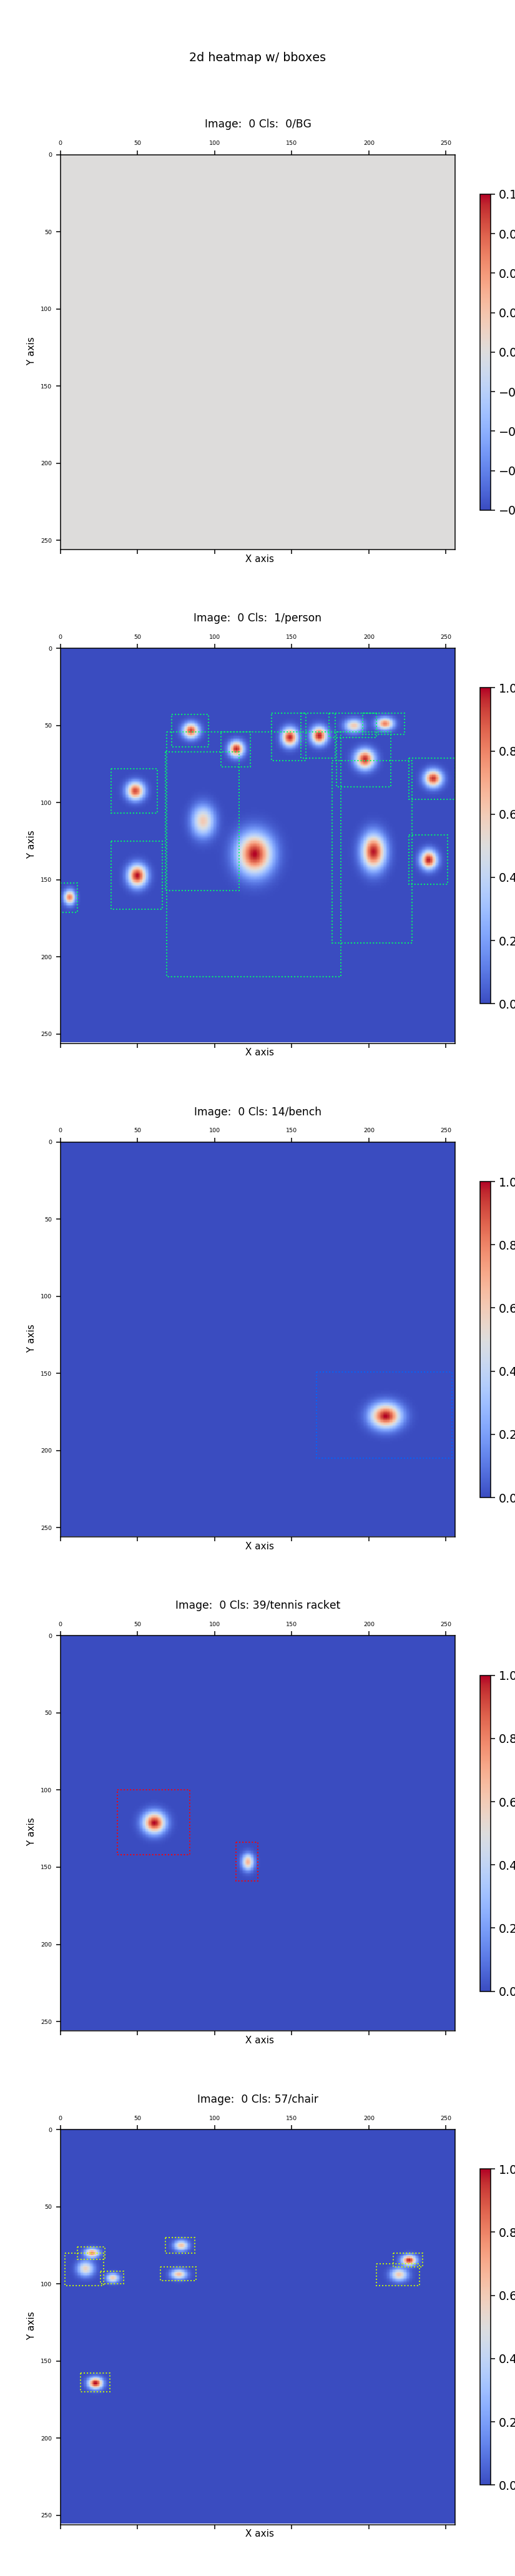

In [15]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    print(pred_heatmap_norm.shape)
    class_ids = np.unique(pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    
#     plot_2d_heatmap_with_bboxes(model_pred_heatmap_norm, model_pred_heatmap_scores, 
#                                 img_id, [0], width=6, height=6, class_names = class_names, scale = 4)
    plot_2d_heatmap_with_bboxes( pred_heatmap_norm,  pred_heatmap_scores, 
                                img_id, class_ids, width=6, height=6, class_names = class_names, scale = 4)    
    
#     plot_2d_heatmap(pred_heatmap_norm, img_id, class_ids, width=6, height=6, class_names = class_names)
#     plot_one_bbox_heatmap(pred_heatmap_norm[img,:,:,cls], pred_heatmap_scores[img,cls,box], )

####  2D plot of `pred_heatmap_norm` returned from model

In [ ]:
for img_id in [0]:     ##range(mrcnn_config.BATCH_SIZE):
    print(pred_heatmap_norm.shape)
    class_ids = np.unique(pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_2d_heatmap_with_bboxes(model_pred_heatmap_norm, model_pred_heatmap_scores, 
                                img_id, [1], width=6, height=6, class_names = class_names, scale = 4)
    plot_2d_heatmap_with_bboxes( pred_heatmap_norm,  pred_heatmap_scores, 
                                img_id, [1], width=6, height=6, class_names = class_names, scale = 4)      
#     plot_2d_heatmap_with_bboxes(pred_heatmap_norm, pred_heatmap_scores, 
#                                 img_id, class_ids, width=6, height=6, class_names = class_names, scale = 4)

    # plot_one_bbox_heatmap(pred_heatmap_norm[img,:,:,cls], pred_heatmap_scores[img,cls,box], )
    #     plot_2d_heatmap(model_pred_heatmap_norm, img_id, class_ids, width=6, height=6, class_names = class_names)


In [ ]:
for img_id in [0]:     ##range(mrcnn_config.BATCH_SIZE):
    print(pred_heatmap_norm.shape)
    class_ids = np.unique(pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_2d_heatmap_with_bboxes(model_pred_heatmap_norm, model_pred_heatmap_scores, 
                                img_id, [9], width=6, height=6, class_names = class_names, scale = 4)
    plot_2d_heatmap_with_bboxes( pred_heatmap_norm,  pred_heatmap_scores, 
                                img_id, [9], width=6, height=6, class_names = class_names, scale = 4)      
#     plot_2d_heatmap_with_bboxes(pred_heatmap_norm, pred_heatmap_scores, 
#                                 img_id, class_ids, width=6, height=6, class_names = class_names, scale = 4)

    # plot_one_bbox_heatmap(pred_heatmap_norm[img,:,:,cls], pred_heatmap_scores[img,cls,box], )
    #     plot_2d_heatmap(model_pred_heatmap_norm, img_id, class_ids, width=6, height=6, class_names = class_names)


####  3D plot of  `pred_heatmap_norm` returned form code above

(1, 256, 256, 81)
Image : 0  ClassIds: [0, 1, 14, 39, 57]
height is  30
shape pos  (256, 256, 2) shape Z:  (256, 256)


<IPython.core.display.Javascript object>


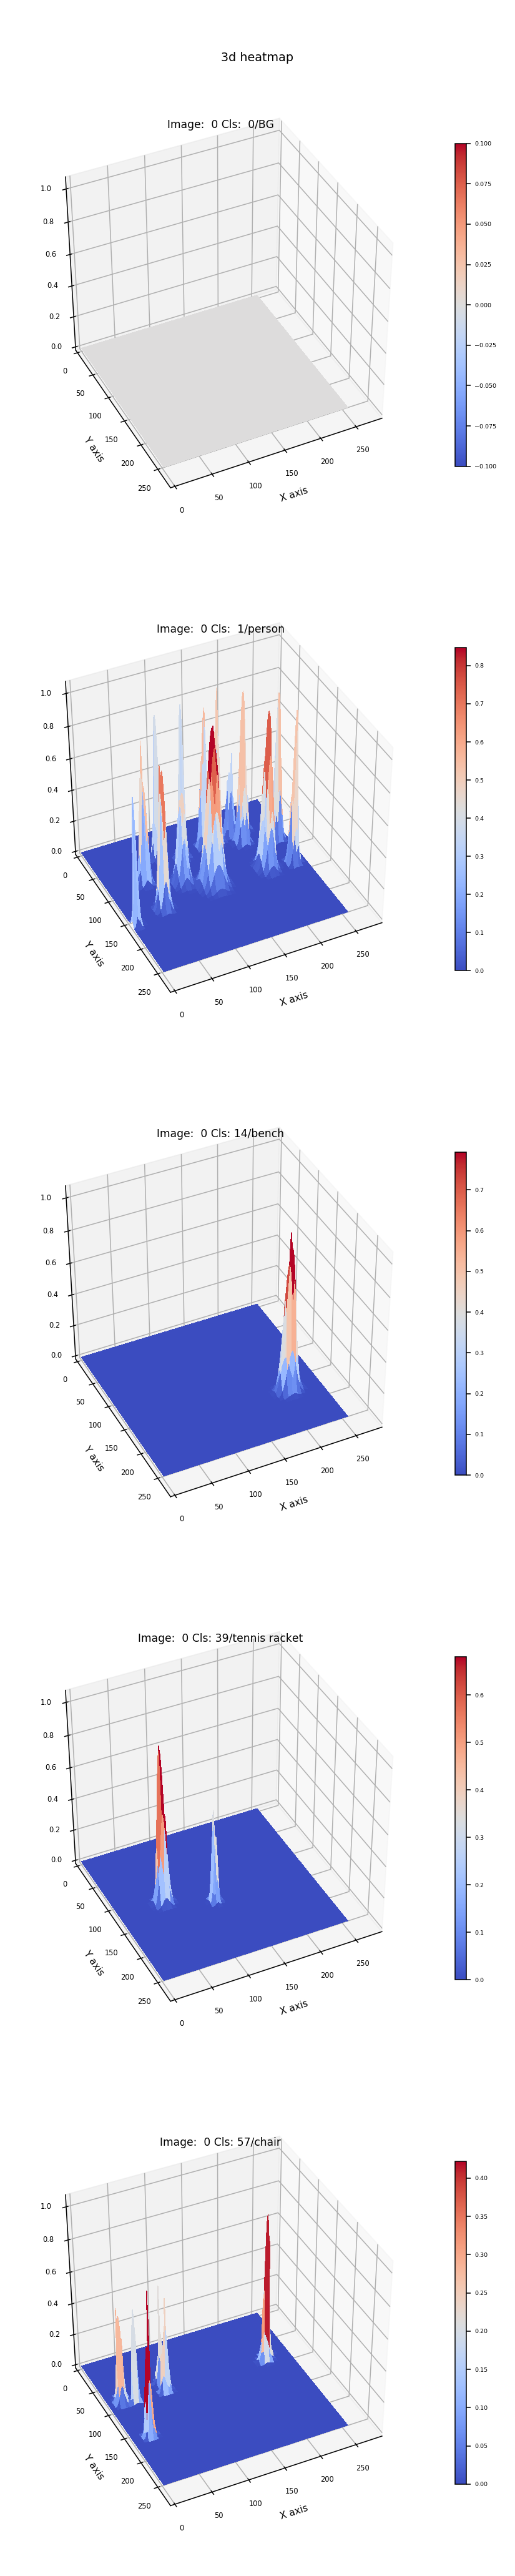

In [17]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    print(pred_heatmap_norm.shape)
    class_ids = np.unique(pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(pred_heatmap_norm, img_id, class_ids, width=6, height=6, class_names = class_names)

#### Verfiy max and min of gaussian heatmaps are 1.0 and 0.0, respectively 

In [18]:
np.set_printoptions(precision=4, threshold=None, linewidth=200, suppress=True)
print(pred_heatmap_norm.shape)
hm_max = np.max(pred_heatmap_norm, axis = (1,2))
hm_min = np.min(pred_heatmap_norm, axis = (1,2))
print(hm_max.shape)
for img_id in range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    class_ids = np.unique(pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('\n Image : {}  ClassIds: {}'.format(img_id, class_ids))
    print('-'*38)
    for cls in class_ids: 
        print(' class: {}   max: {}  min: {}'.format(cls, hm_max[img_id,cls], hm_min[img_id,cls]))
#         print(pred_heatmap_scores[img_id, cls])
        
     

(1, 256, 256, 81)
(1, 81)

 Image : 0  ClassIds: [0, 1, 14, 39, 57]
--------------------------------------
 class: 0   max: 0.0  min: 0.0
 class: 1   max: 1.0  min: 0.0
 class: 14   max: 1.0  min: 0.0
 class: 39   max: 1.0  min: 0.0
 class: 57   max: 1.0  min: 0.0


####  Detection on a random image

In [ ]:
import random
# image_id2 = random.choice(dataset_test.image_ids)
image_id2 = 28
image2, image_meta2, gt_class_id2, gt_bbox2, gt_mask2 =\
    load_image_gt(dataset_test, inference_config, image_id2, use_mini_mask=False)
print(image_meta2)
print(len(image2))

# image_id = img_meta[img_idx,0]
# image = dataset_test.load_image(image_id)
mask2, class_ids2 = dataset_test.load_mask(image_id2)
print('Image id: ',image_id2)
print('Image meta', image_meta2)
print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
visualize.display_top_masks(image2, mask2, class_ids2, dataset_test.class_names)

results = model.detect([image2], verbose=1)
print(type(results))
pp.pprint(results)

print(' mrcnn_detections  :', mrcnn_detections.shape)   # 1, 100, 6
print(mrcnn_detections[:,:15])  

#### Display `gauss_heatmap` 3D heatmap (not normalized, normlized, L2 normalized)

In [ ]:
from mrcnn.visualize import plot_3d_heatmap, plot_2d_heatmap
%matplotlib inline
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 0
cls = 0

# for cls in range(7):
#     print(pred_heatmap_scores[img,cls,:10])

ttl = 'Non-normalized - image: {}'.format(img)
plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
ttl = 'Normalized - image: {}'.format(img)
plot_3d_heatmap(pred_heatmap_norm[img], title = ttl, width = 20)

# ttl = 'Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap[img], title = ttl, width = 20)
# ttl = 'Normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap_norm[img], title = ttl, width = 20)

# ttl = 'Ground Truth Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(gt_heatmap[img], title = ttl, width = 20)
# ttl = 'Ground Truth Normalized - image: {}'.format(img)
# plot_3d_heatmap(gt_heatmap_norm[img], title = ttl, width = 20)


# ttl = 'Non-normalized - image: {}'.format(img)
# plot_2d_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)
# ttl = 'Normalized - image: {}'.format(img)
# plot_2d_heatmap(pred_heatmap_norm[img], pred_heatmap_scores[img], width=15, title=ttl)
